# Model Example figure code

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tqdm
import logging, pickle, copy
logging.basicConfig(filename='./_logs/examples.log',level=logging.DEBUG)
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns

from pyrlap.domains.gridworld import GridWorld
from demoteaching.mdps.discretizedobmdp import DiscretizedObserverBeliefMDPApproximation
from demoteaching.mdps.obs_belief_mdp import ObserverBeliefMDP

In [340]:
#=============================#
#   Build set of ground MDPs  #
#=============================#
danger_r = -1
goal_reward = 10
init_ground = (0, 1)
goal_s = (5, 2)

np.seterr(under="ignore", divide="ignore") #ignore underflow in softmax (-> 0); ignore division by 0

do_temp = .1
do_randchoose = 0.0 #1e-10 #.01
do_discount = .99
show_temp = .02
show_randchoose = 0.00 #1e-10 #.01
show_discount = .99
show_reward = 10
n_trajs = 1000

n_bins = 1
seed_trajs = []
np.random.seed(4234)

mdp_params = []
feature_rewards = []
# for rs in product([0, danger_r], repeat=3):
#     feature_rewards.append(dict(zip('opc', rs)))
for rs in product([0, danger_r], repeat=2):
    feature_rewards.append(dict(zip('pc', rs)))

mdp_codes = []
for fr in feature_rewards:
#     rfc = ['o' if fr[f] == 0 else 'x' for f in 'opc']
    rfc = ['o' if fr[f] == 0 else 'x' for f in 'pc']
    rfc = ''.join(rfc)
    mdp_codes.append(rfc)
    fr['y'] = goal_reward
    fr['.'] = 0
    fr['x'] = danger_r

gridworld_array = [
    '.pccc.',
    '.pcccy',
    '.pccc.',
]
defaultparams = {
    'gridworld_array': gridworld_array,
#     'absorbing_states': [goal_s, ],
    'absorbing_features': ['y', ],
    'init_state': init_ground,
    'wall_action': False,
    'step_cost': 0,
    'wait_action': False,
    'include_intermediate_terminal': True
}

planners = {}
for mdpc, frewards in zip(mdp_codes, feature_rewards):
    mdp = GridWorld(**{
        **defaultparams, 
        'feature_rewards': frewards
    })
    planner = mdp.solve(
        softmax_temp=do_temp/2, 
        randchoose=do_randchoose, 
        discount_rate=do_discount)
    seed_trajs.extend([planner.run() for _ in range(100)])
    planners[mdpc] = planner

#===========================================#
#   Build Observer Belief MDP and support   #
#===========================================#
obplanners = {}
discretized_tf = None
for true_mdp_code in mdp_codes:
    obmdp = DiscretizedObserverBeliefMDPApproximation(
        n_probability_bins=n_bins,
        seed_trajs=seed_trajs,
        branch_steps=0,
        discretized_tf=discretized_tf,
        planners=planners,
        true_planner_name=true_mdp_code,
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=show_reward,
        update_includes_intention=True
    )
    discretized_tf = obmdp.get_discretized_tf()
    obplanner = obmdp.solve(
        softmax_temp=show_temp,
        randchoose=show_randchoose,
        discount_rate=show_discount
    )
    obplanners[true_mdp_code] = obplanner

In [341]:
#first order observer
ob1_mdp = ObserverBeliefMDP(
    planners=planners,
    true_planner_name=mdp_codes[0],
    belief_reward_type='true_gain',
    only_belief_reward=False,
    belief_reward=show_reward,
    update_includes_intention=True
)

In [342]:
# Basic Second-order reasoning MDP (certain pragmatic reasoner)
ob2_mdp = ObserverBeliefMDP(
    planners=obplanners,
    true_planner_name=true_mdp_code,
    belief_reward_type='true_gain',
    only_belief_reward=False,
    belief_reward=show_reward,
    update_includes_intention=True
)

In [343]:
# Joint communication/non-communicative reasoning

#first add the communicative planners; then create the non-communicative planners
obplanners2 = {mdpc+"_com":pl for mdpc, pl in obplanners.items()}
for true_mdp_code in mdp_codes:
    obmdp = DiscretizedObserverBeliefMDPApproximation(
        n_probability_bins=n_bins,
        seed_trajs=seed_trajs,
        branch_steps=0,
        discretized_tf=discretized_tf,
        planners=planners,
        true_planner_name=true_mdp_code,
        belief_reward_type='true_gain',
        only_belief_reward=False,
        belief_reward=0,
        update_includes_intention=True
    )
    discreteized_tf = obmdp.get_discretized_tf()
    obplanner = obmdp.solve(
        softmax_temp=show_temp,
        randchoose=show_randchoose,
        discount_rate=show_discount
    )
    obplanners2[true_mdp_code+"_nocom"] = obplanner

# observer mdp that reasons about whether the demonstrator is communicating or not
ob2_joint_mdp = ObserverBeliefMDP(
    planners=obplanners2,
    true_planner_name=true_mdp_code+"_nocom",
    belief_reward_type='true_gain',
    only_belief_reward=False,
    belief_reward=show_reward,
    update_includes_intention=True
)
b2j_order = ob2_joint_mdp.planner_order

In [344]:
from functools import lru_cache
from scipy.spatial import distance

@lru_cache()
def get_closest(b, B):
    bestdist = float('inf')
    best = None
    for b_ in B:
#         dist = np.sqrt(np.subtract(b, b_)**2).sum()
        dist = distance.euclidean(b, b_)
        if  dist < bestdist:
            best = b_
            bestdist = dist
    return best

def get_observers_traj(satraj, rfc, mdp_codes, commcode="_com"):
    """Returns table of observer trajectories for different types of observers
    (literal, pragmatic, uncertain pragmatic)"""

    trajdata = []
    b1tup = ob1_mdp.get_init_state()[0]
    b2tup = ob2_mdp.get_init_state()[0]
    b2jtup = ob2_joint_mdp.get_init_state()[0]

    # b2jcodes = ["_".join([rfc_, c_]) for c_, rfc_ in product(["com", "nocom"], mdp_codes)]
    b2jcodes = ob2_joint_mdp.planner_order
    B1tups = frozenset([b for b, w in list(ob2_mdp.planners[0].action_value_function.keys())])
    for t, ((s, a), (ns, _)) in enumerate(zip(satraj, satraj[1:])):
        tdata = {}
        tdata.update({
            't': t,
            'mdp_code': rfc,
            'state': s,
            'action': a
        })

        #first-order updates
        tdata.update({"b1."+c: b for c, b in zip(mdp_codes, b1tup)})
        tdata['b1.target'] = b1tup[mdp_codes.index(rfc)]
        nb1_dist = ob1_mdp.transition_dist((b1tup, s), a)
        nb1tup = [b for b, ns_ in nb1_dist.keys() if ns_ == ns][0]
        nb1tup = get_closest(nb1tup, B1tups)

        #second-order updates
        tdata.update({"b2."+c: b for c, b in zip(mdp_codes, b2tup)})
        tdata['b2.target'] = b2tup[mdp_codes.index(rfc)]
        nb2_dist = ob2_mdp.transition_dist((b2tup, (b1tup, s)), a)
        nb2tup = [nb2 for nb2, (nb_, ns_) in nb2_dist.keys() if np.allclose(nb_, nb1tup) and ns_ == ns][0]

        #joint second-order updates
        tdata.update({"b2j."+c: b for c, b in zip(b2jcodes, b2jtup)})
        tdata['b2j.target'] = sum([b for b, code in zip(b2jtup, b2jcodes) if rfc in code])
        tdata['b2j.com'] = sum([b for b, code in zip(b2jtup, b2jcodes) if "_com" in code])
        tdata['b2j.nocom'] = sum([b for b, code in zip(b2jtup, b2jcodes) if "_nocom" in code])
        nb2j_dist = ob2_joint_mdp.transition_dist((b2jtup, (b1tup, s)), a)
        nb2jtup = [nb2j for nb2j, (nb_, ns_) in nb2j_dist.keys() if np.allclose(nb_, nb1tup) and ns_ == ns][0]
        
        tdata.update({"pD."+c+"_com": obplanners2[c+"_com"].act_dist((b1tup, s)).get(a, 0.0) for c in mdp_codes})
        tdata.update({"pD."+c+"_nocom": obplanners2[c+"_com"].act_dist((b1tup, s)).get(a, 0.0) for c in mdp_codes})

        trajdata.append(tdata)
        b1tup = nb1tup
        b2tup = nb2tup
        b2jtup = nb2jtup
    return pd.DataFrame(trajdata)

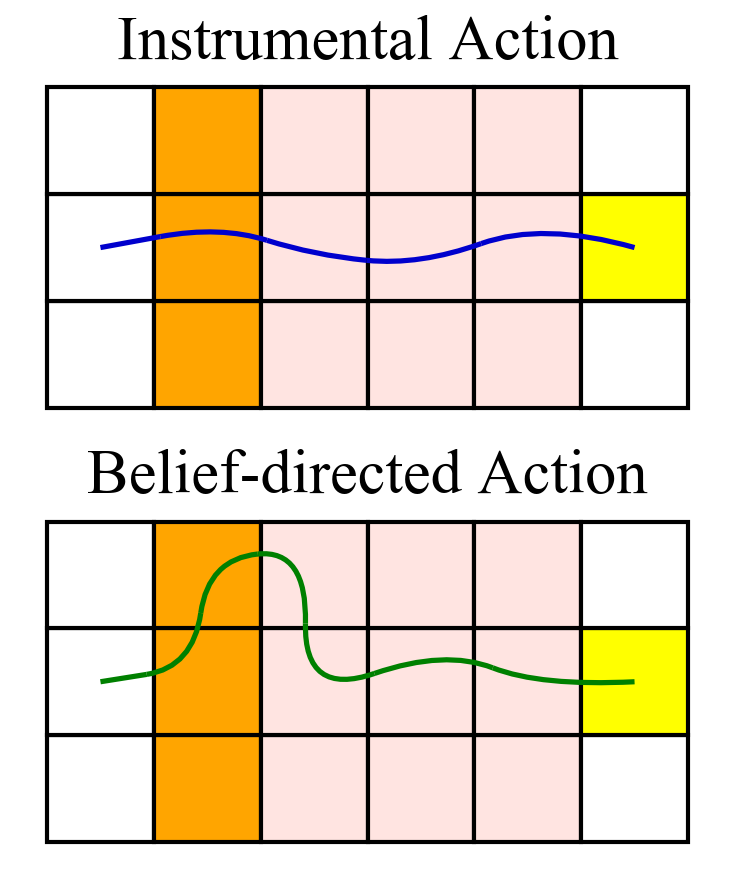

In [462]:
import matplotlib.pyplot as plt
rfc = 'oo'
fig, axes = plt.subplots(2, 1, figsize=(5, 6), dpi=150)
gw = GridWorld(**defaultparams)
gwp = gw.plot(feature_colors={'p':'orange', 'c':'mistyrose'}, ax=axes[0])
obs_trajs = []
ntraj = 1
for ti in range(ntraj):
    satraj = [(sansr.s[1], sansr.a) for sansr in obplanners2[rfc+"_nocom"].run()[:-1]]
    gwp.plot_trajectory(satraj, color='mediumblue', lw=2.5, jitter_var=.15)
    obs_traj = get_observers_traj(satraj, rfc, mdp_codes, commcode="_com")
    obs_traj['traj_i'] = ti
    obs_traj['dem'] = 'do'
    obs_trajs.append(obs_traj)
axes[0].set_title("Instrumental Action", fontsize=30, fontfamily="Times New Roman")
    
gwp = gw.plot(feature_colors={'p':'orange', 'c':'mistyrose'}, ax=axes[1])
show_obs_trajs = []
for ti in range(ntraj):
    satraj = [(sansr.s[1], sansr.a) for sansr in obplanners[rfc].run()[:-1]]
    gwp.plot_trajectory(satraj, color='green', lw=2.5, jitter_var=.15)
    obs_traj = get_observers_traj(satraj, rfc, mdp_codes, commcode="_com")
    obs_traj['traj_i'] = ti
    obs_traj['dem'] = 'show'
    obs_trajs.append(obs_traj)
axes[1].set_title("Belief-directed Action", fontsize=30, fontfamily="Times New Roman")

fig.tight_layout()

In [389]:
obs_trajs = []
ntraj = 50
for ti in range(ntraj):
    satraj = [(sansr.s, sansr.a) for sansr in planners[rfc].run()[:-1]]
    obs_traj = get_observers_traj(satraj, rfc, mdp_codes, commcode="_com")
    obs_traj['traj_i'] = ti
    obs_traj['dem'] = 'do'
    obs_trajs.append(obs_traj)
    
for ti in range(ntraj):
    satraj = [(sansr.s[1], sansr.a) for sansr in obplanners[rfc].run()[:-1]]
    obs_traj = get_observers_traj(satraj, rfc, mdp_codes, commcode="_com")
    obs_traj['traj_i'] = ti
    obs_traj['dem'] = 'show'
    obs_trajs.append(obs_traj)

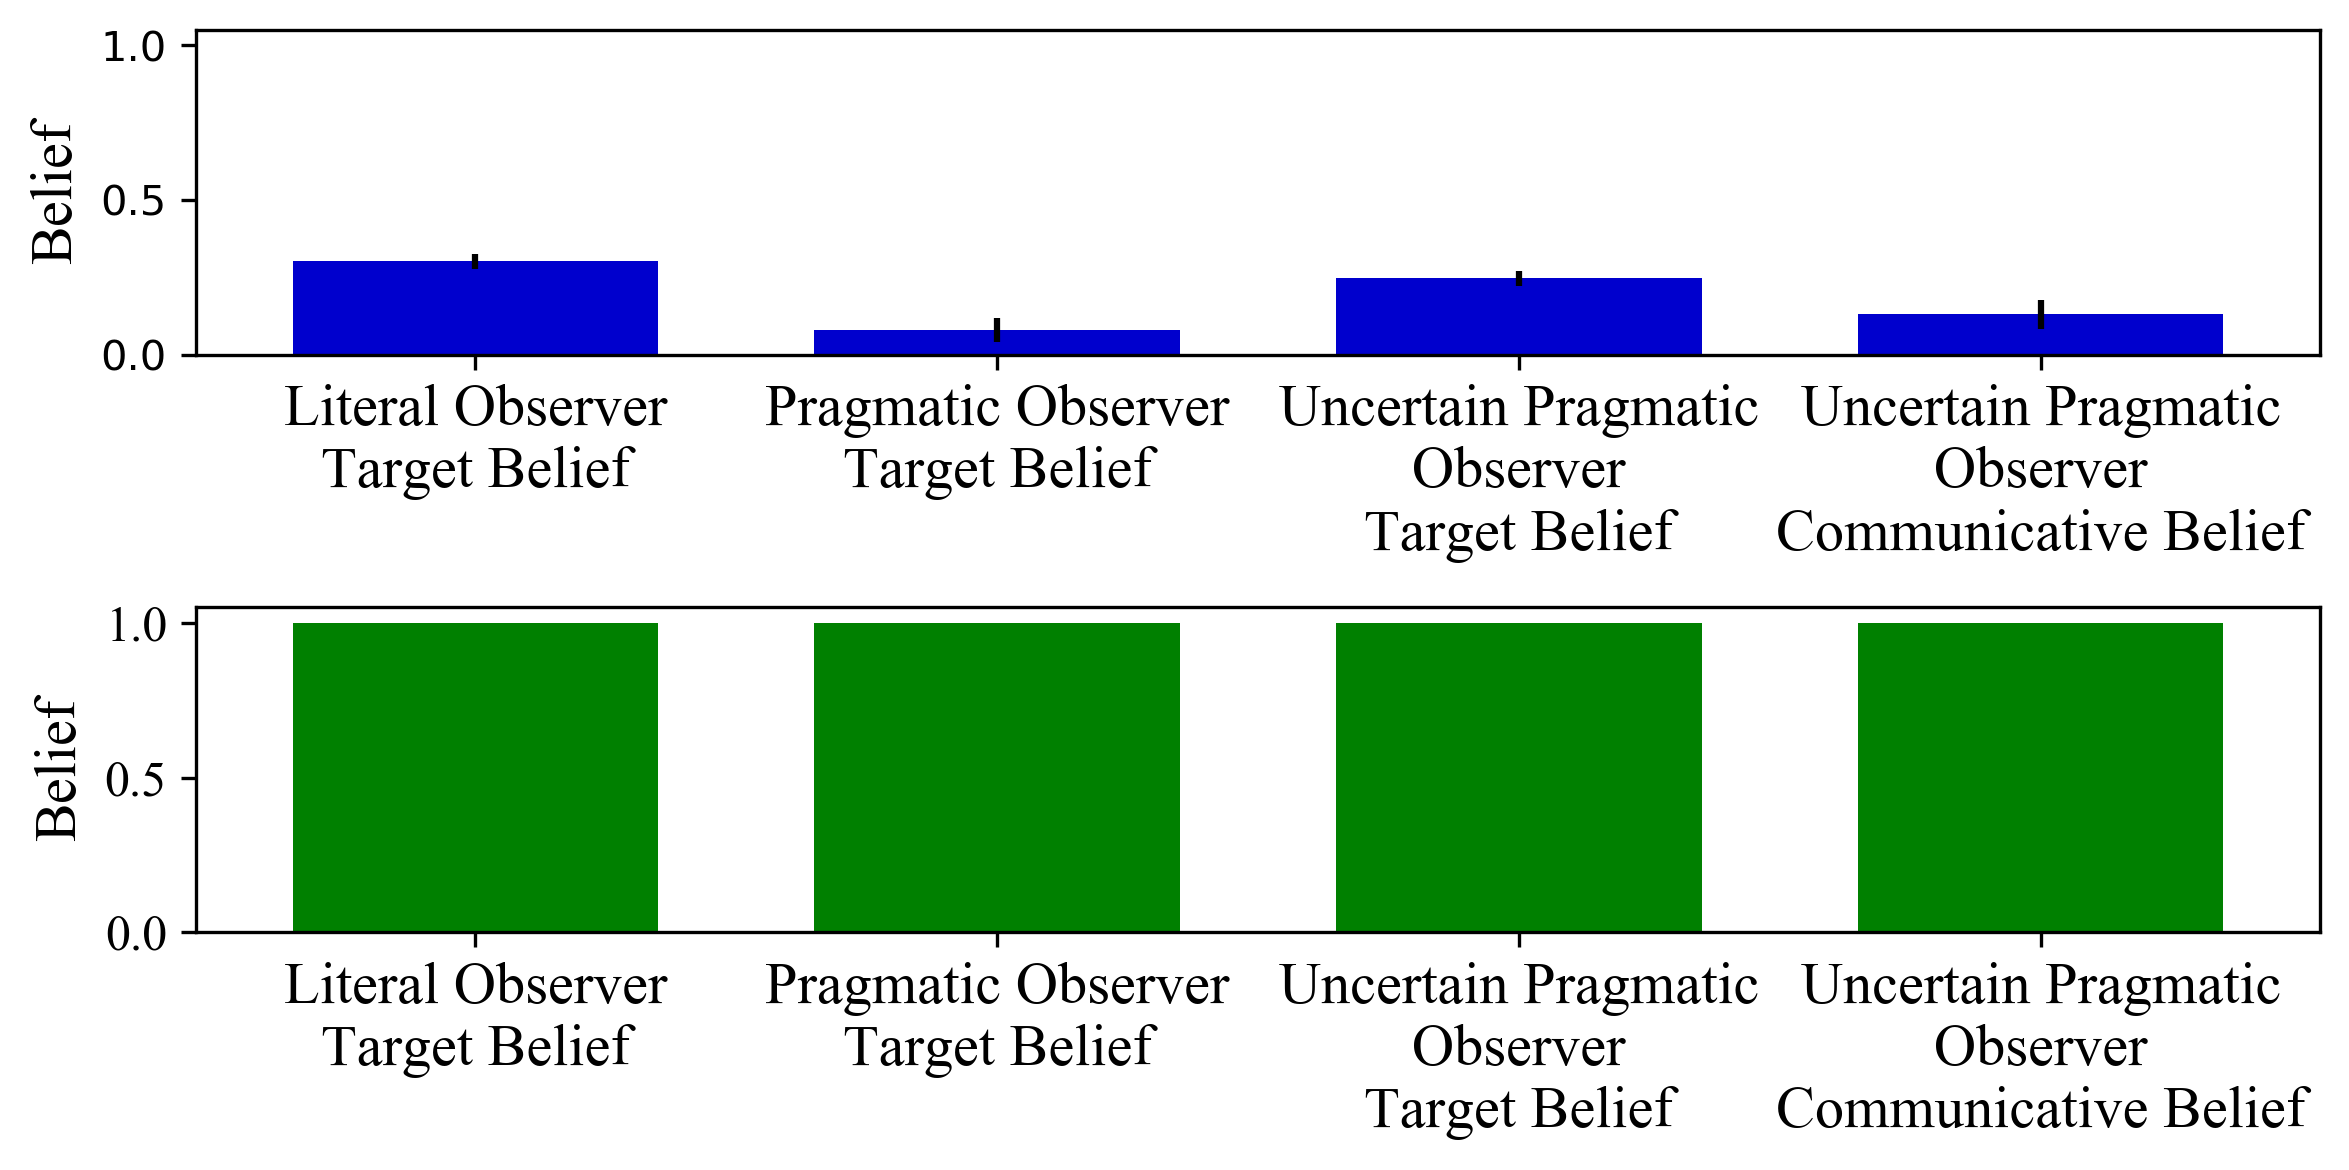

In [397]:
obs = pd.concat(obs_trajs)
obs = obs.groupby(['dem', "traj_i"]).apply(lambda r: r[['b1.target', 'b2.target', 'b2j.target', 'b2j.com']].iloc[-1])
obsmeans = obs.groupby('dem')[['b1.target', 'b2.target', 'b2j.target', 'b2j.com']].mean()
obssem = obs.groupby('dem')[['b1.target', 'b2.target', 'b2j.target', 'b2j.com']].sem()

fig, axes = plt.subplots(2, 1, figsize=(8, 4), dpi=300)
x = np.array([0, 1, 2, 3])
labels = [
    "Literal Observer\nTarget Belief",
    "Pragmatic Observer\nTarget Belief",
    "Uncertain Pragmatic\nObserver\nTarget Belief",
    "Uncertain Pragmatic\nObserver\nCommunicative Belief",
]
width = .7

ax = axes[0]
rects1 = ax.bar(x, obsmeans.T['do'], width, label='Do', color='mediumblue')
ax.errorbar(x, obsmeans.T['do'], yerr = obssem.T['do'], ls='none', color='k')
ax.set_ylabel('Belief', fontsize=14, fontfamily="Times New Roman")
# ax.set_title('', fontsize=22, fontfamily="Times New Roman")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, fontfamily="Times New Roman")
plt.yticks(fontsize=12, fontfamily="Times New Roman")
ax.set_ylim(0, 1.05)
# ax.legend()

ax = axes[1]
rects2 = ax.bar(x, obsmeans.T['show'], width, label='Show', color='green')
ax.errorbar(x, obsmeans.T['show'], yerr = obssem.T['show'], ls='none', color='k')
ax.set_ylabel('Belief', fontsize=14, fontfamily="Times New Roman")
# ax.set_title('', fontsize=22, fontfamily="Times New Roman")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14, fontfamily="Times New Roman")
ax.set_ylim(0, 1.05)
# ax.legend()

fig.tight_layout()

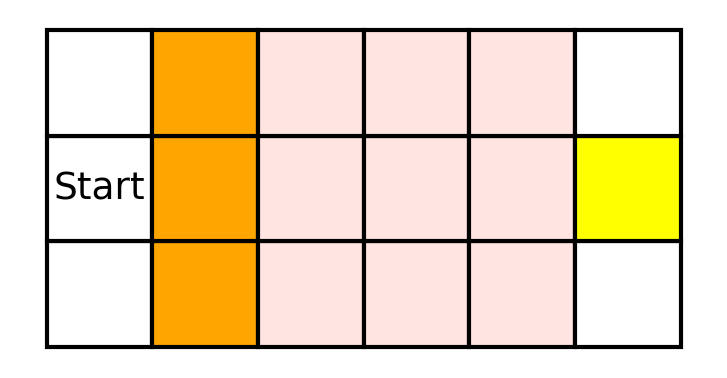

In [475]:
gw = GridWorld(**{**defaultparams})
fig, ax = plt.subplots(dpi=150)
gwp = gw.plot(feature_colors={'p':'orange', 'c':'mistyrose'}, ax=ax)
gwp.annotate(0, 1, "Start", ha="center", va="center", fontsize=18)
